In [8]:
from __future__ import print_function, division

import time
import os
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from skimage import io, transform

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, models, transforms, utils

cudnn.benchmark = True
plt.ion()   # interactive mode

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [23]:
# path constants
path_to_folder = 'Assignment3_Massaged_Data'
train_images_folder = 'train_set_edges'
test_images_folder = 'test_set_luma'
path_to_train_images= path_to_folder + '/' + train_images_folder
path_to_test_images = path_to_folder + '/' + test_images_folder

path_to_train_labels= path_to_folder + '/' + 'train_labels.csv'

In [24]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.ToTensor()
    ]),
}

In [123]:
class DatasetCustom(Dataset):
    
    def __init__(self, root_dir, csv_path, transform=None):
        self.root = root_dir
        self.dataframe = pd.read_csv(csv_path)
        self.transform = transform
        
    def __len__(self):
        return self.dataframe.shape[0]-1
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        img_name = os.path.join(self.root,
                                self.dataframe.iloc[index, 0])
        
        edges_mask = io.imread(img_name)
        
        # Added, since my images are in black and white (luma edges)
        image = np.zeros((edges_mask.shape[0], edges_mask.shape[1], 3))
        image[:,:,0] = edges_mask
        image[:,:,1] = edges_mask
        image[:,:,2] = edges_mask
        image = image.astype(np.uint8)
        
        
        label = (self.dataframe.iloc[index, 2])
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [124]:
train_dataset = DatasetCustom(path_to_train_images, path_to_train_labels, transform=data_transforms['train'])

In [125]:
dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=0)

# Show some training images

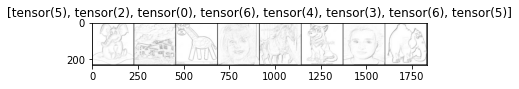

In [126]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
inputs, labels = next(iter(dataloader))
out = utils.make_grid(inputs[0:8])
imshow(out, title=[x for x in labels[0:8]])


# GPU availability

In [16]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")

# Training loop function

In [127]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Model selection

In [136]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
fully_connected  = nn.Sequential(nn.Linear(num_ftrs, 7),
                                nn.Softmax(dim=1))
model.fc = fully_connected
model = model.to(device)

# Loss function

In [129]:
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler

In [137]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training

In [131]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


  1%|          | 1/95 [00:12<19:40, 12.55s/it]


KeyboardInterrupt: 

# Test data loader

In [132]:
class TestDatasetCustom(Dataset):
    
    def __init__(self, root_dir, transform=None):
        import glob
        self.root = root_dir
        files = glob.glob(root_dir+'/*.png')
        self.files = [root_dir + '/' + str(i) + '.png' for i in range(len(files))]
        self.transform = transform
    
    def file_getter(self):
        return self.files
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        
        if torch.is_tensor(index):
            index = index.tolist()
        
        edges_mask = io.imread(self.files[index])
        
        # Added, since my images are in black and white (luma edges)
        image = np.zeros((edges_mask.shape[0], edges_mask.shape[1], 3))
        image[:,:,0] = edges_mask
        image[:,:,1] = edges_mask
        image[:,:,2] = edges_mask
        image = image.astype(np.uint8)
        
        if self.transform is not None:
            image = self.transform(image)
            
        img_name = self.files[index].split('/')[-1]
            
        return img_name, image

In [133]:
# test_dir = "/kaggle/input/classification-of-an-out-of-distribution-dataset/test_set/test_set"
test_dataset = TestDatasetCustom(path_to_test_images, transform=data_transforms['train'])

In [134]:
test_dataloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=False, num_workers=0)

# Saving the result

In [138]:
total = 0
empty_dictionary = {'id': np.zeros((len(test_dataloader))), 'label': np.zeros((len(test_dataloader)))}
predicted_df = pd.DataFrame(data=empty_dictionary)
predicted_df['id'] = predicted_df['id'].apply(str)
predicted_df['label'] = predicted_df['label'].astype(int)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for index, values in enumerate(tqdm(test_dataloader)):
        # calculate outputs by running images through the network
        image = values
        image_name = image[0]
        image_file = image[1]
        image_file = image_file.cpu().float()
        model_ft = model_ft.cpu()
        output = model_ft(image_file)
        
        _, predicted = torch.max(output.data, 1)
        
        if index==1 or index==10 or index==20:
            out = torchvision.utils.make_grid(image_file)
            imshow(out)
            print(output)
        
        predicted_df.at[index,'id'] = image_name[0]
        predicted_df.at[index,'label'] = str(predicted.numpy()[0])
        

0it [00:00, ?it/s]


In [ ]:
predicted_df.to_csv('rjching_15-04-2022_7.csv', index = False)